Este código surge no contexto da competição "Dogs vs. Cats" do Kaggle, criada pela Profa. Manoela para a disciplina de Técnicas Tradicionais de Classificação de Imagens do curso VC Master da PUC-Rio. O desafio para os alunos era alcançar a melhor acurácia na classificação de imagens de cães e gatos, utilizando apenas visão computacional clássica e modelos tradicionais de Machine Learning. Essa limitação metodológica foi intencional, com o objetivo didático de aprofundar o entendimento das técnicas fundamentais de classificação de imagens.

Referência:

profManoela. VCMaster 24.2 - Dogs vs. Cats. https://kaggle.com/competitions/vc-master-24-2-dogs-vs-cats, 2025. Kaggle.

# Importação das biliotecas utilizadas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split


# Carregamento da Base de Dados e Exploração de Dados

In [2]:
!ls /kaggle/input/vc-master-24-2-dogs-vs-cats/train | head -n 5

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
ls: write error: Broken pipe


In [3]:
!ls /kaggle/input/vc-master-24-2-dogs-vs-cats/samples | head -n 5

100.jpg
101.jpg
102.jpg
103.jpg
104.jpg


# Redimensionamento

In [4]:
def load_images_from_folder(folder, img_size, labels_dict=None, max_images=None, sort=False):
    images = []
    labels = []

    file_list = os.listdir(folder)
    # Ordenar os arquivos numericamente (por conta do submission file)
    if sort:
        file_list = sorted(file_list, key=lambda x: int(x.split('.')[0]))

    for filename in file_list:
        if max_images and len(images) >= max_images:
            break
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize((img_size, img_size)).convert('RGB')
            img_array = np.array(img)
            images.append(img_array)
            # Etiquetar as imagens: 0 para gato, 1 para cachorro
            if labels_dict:
                labels.append(labels_dict[filename])
            elif 'cat' in filename:
                labels.append('cat')
            elif 'dog' in filename:
                labels.append('dog')
    return np.array(images), np.array(labels)

1. Carrega imagens de um diretório, redimensiona-as e opcionalmente atribui rótulos

    Esta função percorre todos os arquivos `.jpg` em um diretório especificado,
    abre cada imagem usando a biblioteca PIL (Pillow), redimensiona-a para um tamanho
    quadrado definido (`img_size` x `img_size`) e converte para o modo de cor RGB.
    As imagens são armazenadas como arrays NumPy em uma lista.
   * folder (str): Caminho para o diretório contendo as imagens.
   * img_size (int): Tamanho desejado para as imagens quadradas (largura e altura).
   * labels_dict (dict, optional): Dicionário opcional para mapear nomes de arquivos a rótulos.
                                     Se fornecido, usa este dicionário para atribuir rótulos.
                                     Padrão é None.
   * max_images (int, optional): Número máximo de imagens a serem carregadas. Se fornecido,
                                    a função para de carregar imagens quando este limite é atingido.
                                    Padrão é None (carrega todas as imagens no diretório).
   * sort (bool, optional): Se True, ordena a lista de arquivos numericamente antes de carregar.
                              Útil para garantir ordem consistente, especialmente para arquivos
                              nomeados sequencialmente (ex: '1.jpg', '2.jpg', '3.jpg').
                              Padrão é False.

2. Retorna:Uma tupla contendo dois arrays NumPy:
   * images (np.ndarray): Um array NumPy 4D onde cada elemento representa uma imagem
              redimensionada e convertida para RGB. 
   * labels (np.ndarray): Um array NumPy 1D contendo os rótulos correspondentes a cada imagem.




In [5]:
train_folder = '/kaggle/input/vc-master-24-2-dogs-vs-cats/train'
submission_folder = '/kaggle/input/vc-master-24-2-dogs-vs-cats/samples'
img_size = 64  # Redimensionar imagens para 64x64 pixels

# Carregar imagens de treino
X_train, y_train = load_images_from_folder(train_folder, img_size)

# Para o conjunto de teste, podemos simplesmente carregar as imagens sem etiquetas
# ou usar um conjunto de validação a partir dos dados de treinamento
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_submission, _ = load_images_from_folder(submission_folder, img_size, sort=True)

1. Definição de Diretórios e Parâmetros:

* train_folder: Caminho para as imagens de treinamento.
* submission_folder: Caminho para as imagens de submissão.
* img_size: Tamanho para redimensionar as imagens (64x64 pixels).

2. Carregamento de Dados de Treinamento:

* Usa a função load_images_from_folder para carregar imagens do diretório de treinamento.
* Retorno: X_train (imagens) e y_train (rótulos).
   
3. Separação de Dados:

* Divide os dados de treinamento em conjuntos de treinamento e validação usando train_test_split.
* Parâmetros: test_size=0.2 (20% para validação) e random_state=42 (para reprodução).

4. Carregamento de Dados para Submissão:

* Carrega imagens do diretório de submissão.
* Retorno: X_submission (imagens redimensionadas) e ignora os rótulos (_).

5. Função load_images_from_folder:

* Carrega imagens de um diretório, redimensiona para img_size, converte para RGB e extrai rótulos das pastas.
* Retorno: Tupla com arrays NumPy de imagens e rótulos.

6. Retorno:

* X_train, X_test, y_train, y_test: Arrays NumPy para treinamento e validação.
* X_submission: Array NumPy para submissão.

7. Uso:
Prepara dados para treinamento de modelos de classificação de imagens.

In [6]:
# Função para detectar imagens corrompidas
def detect_corrupted_images(folder):
    corrupted_files = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            try:
                img = Image.open(os.path.join(folder, filename))
                img.verify()  # Verificar a integridade do arquivo
            except (IOError, SyntaxError) as e:
                corrupted_files.append(filename)
    return corrupted_files

# Detectar imagens corrompidas
corrupted_train_images = detect_corrupted_images(train_folder)
print(f"Imagens corrompidas no conjunto de treino: {corrupted_train_images}")

corrupted_submission_images = detect_corrupted_images(submission_folder)
print(f"Imagens corrompidas no conjunto de submissão: {corrupted_submission_images}")

Imagens corrompidas no conjunto de treino: []
Imagens corrompidas no conjunto de submissão: []


* Função para Detectar Imagens Corrompidas: 
a função detect_corrupted_images é projetada para identificar imagens corrompidas em um diretório especificado. Ela verifica cada arquivo com extensão .jpg tentando abri-lo e verificar sua integridade. Se ocorrer uma exceção durante a abertura ou verificação da imagem, o nome do arquivo é adicionado à lista de arquivos corrompidos.

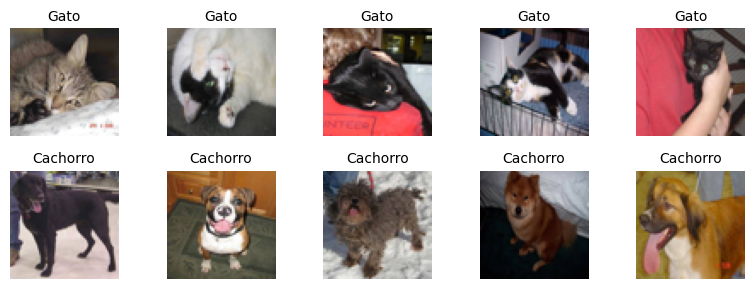

In [7]:


import random
import matplotlib.pyplot as plt

# Separe os índices de gatos e cachorros
gato_indices = [i for i, label in enumerate(y_train) if label == 'cat']
cachorro_indices = [i for i, label in enumerate(y_train) if label == 'dog']

# Seleciona 5 imagens aleatórias de gatos e 5 de cachorros
gato_selecionados = random.sample(gato_indices, 5)
cachorro_selecionados = random.sample(cachorro_indices, 5)

# Cria a figura
plt.figure(figsize=(8, 3))

# Plota as imagens de gatos
for i, idx in enumerate(gato_selecionados):
    image = X_train[idx]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title('Gato', fontsize=10)
    plt.axis('off')

# Plota as imagens de cachorros
for i, idx in enumerate(cachorro_selecionados):
    image = X_train[idx]
    plt.subplot(2, 5, i + 6)  # Começa em 6 porque já plotamos 5 imagens de gatos
    plt.imshow(image, cmap='gray')
    plt.title('Cachorro', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

O código é utilizado para plotar imagens de gatos e cachorros com seus respectivos rótulos. Ele seleciona aleatoriamente 10 imagens do conjunto de treinamento X_train e exibe cada uma delas em um subplot, junto com seu rótulo correspondente em y_train.

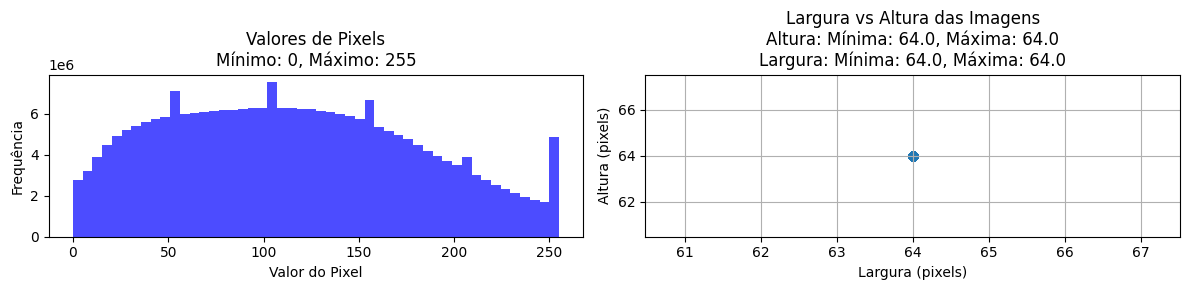

In [8]:
# Obter valores mínimos e máximos dos pixels
pixel_min = np.min(X_train)
pixel_max = np.max(X_train)

# Obter dimensões das imagens
image_heights = X_train.shape[1] * np.ones(X_train.shape[0])
image_widths = X_train.shape[2] * np.ones(X_train.shape[0])

# Plotar valores mínimos e máximos dos pixels
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(X_train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Valores de Pixels\nMínimo: {pixel_min}, Máximo: {pixel_max}')
plt.xlabel('Valor do Pixel')
plt.ylabel('Frequência')

# Plotar gráfico de dispersão de largura vs altura
plt.subplot(1, 2, 2)
plt.scatter(image_widths, image_heights, alpha=0.5)
plt.title(f'Largura vs Altura das Imagens\nAltura: Mínima: {image_heights.min()}, Máxima: {image_heights.max()}\nLargura: Mínima: {image_widths.min()}, Máxima: {image_widths.max()}')
plt.xlabel('Largura (pixels)')
plt.ylabel('Altura (pixels)')
plt.grid(True)

plt.tight_layout()
plt.show()

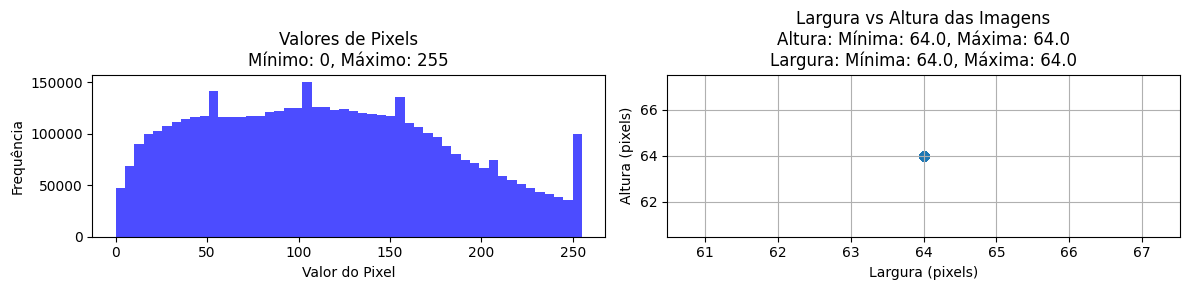

In [9]:
# Base de Submissão
# Obter valores mínimos e máximos dos pixels
pixel_min = np.min(X_submission)
pixel_max = np.max(X_submission)

# Obter dimensões das imagens
image_heights = X_submission.shape[1] * np.ones(X_submission.shape[0])
image_widths = X_submission.shape[2] * np.ones(X_submission.shape[0])

# Plotar valores mínimos e máximos dos pixels
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(X_submission.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Valores de Pixels\nMínimo: {pixel_min}, Máximo: {pixel_max}')
plt.xlabel('Valor do Pixel')
plt.ylabel('Frequência')

# Plotar gráfico de dispersão de largura vs altura
plt.subplot(1, 2, 2)
plt.scatter(image_widths, image_heights, alpha=0.5)
plt.title(f'Largura vs Altura das Imagens\nAltura: Mínima: {image_heights.min()}, Máxima: {image_heights.max()}\nLargura: Mínima: {image_widths.min()}, Máxima: {image_widths.max()}')
plt.xlabel('Largura (pixels)')
plt.ylabel('Altura (pixels)')
plt.grid(True)

plt.tight_layout()
plt.show()

Este código tem como objetivo analisar um conjunto de dados de submissão de imagens (representado pela variável X_submission), focando nos valores dos pixels e nas dimensões das imagens.

# Normalização de Dados

In [10]:
# Normalizar os dados
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_submission = X_submission.astype('float32') / 255.0

Os dados são convertidos para o tipo float32 para permitir operações de ponto flutuante.
Em seguida, os valores são divididos por 255.0, que é o valor máximo típico para dados de imagem em escala de cinza ou RGB, onde cada canal de cor varia de 0 a 255.


In [11]:
# Verificar formas dos dados carregados
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_submission shape: {X_submission.shape}')

X_train shape: (20000, 64, 64, 3)
y_train shape: (20000,)
X_test shape: (5000, 64, 64, 3)
y_test shape: (5000,)
X_submission shape: (400, 64, 64, 3)


In [12]:
train_unique_values, train_counts = np.unique(y_train, return_counts=True)
print("Valores únicos:", train_unique_values)
print("Contagens:", train_counts)

Valores únicos: ['cat' 'dog']
Contagens: [ 9999 10001]


# Aplicação do HOG 

Este código tem como objetivo extrair características HOG (Histogram of Oriented Gradients) de um conjunto de imagens

In [13]:
def extrair_caracteristicas_hog(imagens):
    """Extrai características HOG de uma lista de imagens."""
    caracteristicas_hog_lista = []
    for imagem in imagens:
        # Certifique-se de que a imagem está em escala de cinza (HOG geralmente funciona melhor assim)
        if len(imagem.shape) > 2 and imagem.shape[2] > 1: # Se for colorida, converte para cinza
            from skimage.color import rgb2gray
            imagem_cinza = rgb2gray(imagem)
        else:
            imagem_cinza = imagem # Já está em cinza ou é uma imagem 2D

        # Calcula as características HOG
        caracteristicas = hog(imagem_cinza, orientations=8, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False, channel_axis=None) # channel_axis=None para imagem em escala de cinza
        caracteristicas_hog_lista.append(caracteristicas)
    return np.array(caracteristicas_hog_lista) # Converte para numpy array

# Extrai características HOG das imagens de treino, teste e submission
X_train_hog = extrair_caracteristicas_hog(X_train)
X_test_hog = extrair_caracteristicas_hog(X_test)
X_submission_hog = extrair_caracteristicas_hog(X_submission)

print("Shape dos dados HOG antes do PCA:")
print("X_train_hog shape:", X_train_hog.shape)
print("X_test_hog shape:", X_test_hog.shape)
print("X_submission_hog shape:", X_submission_hog.shape)

Shape dos dados HOG antes do PCA:
X_train_hog shape: (20000, 1568)
X_test_hog shape: (5000, 1568)
X_submission_hog shape: (400, 1568)


* Extração de Características HOG: Utiliza a técnica HOG para obter características relevantes das imagens, úteis para tarefas de classificação.

Este código é uma ferramenta útil para pré-processar dados de imagem, preparando-os para técnicas de aprendizado de máquina que se beneficiem de características HOG e redução de dimensionalidade via PCA.

# Aplicando PCA

* Redução de Dimensionalidade com PCA: Prepara os dados para a aplicação do PCA, reduzindo a dimensionalidade e melhorando a eficiência computacional.
* Análise de Dados: Fornece informações sobre as dimensões dos dados HOG, ajudando na compreensão da estrutura dos dados antes da redução de dimensionalidade.

In [14]:
def aplicar_pca(X_train_hog, X_test_hog, X_submission_hog, n_componentes=50):
    """Aplica PCA aos dados HOG."""
    pca = PCA(n_components=n_componentes)
    X_train_pca = pca.fit_transform(X_train_hog) # Fit no treino e transforma o treino
    X_test_pca = pca.transform(X_test_hog)       # Aplica a transformação aprendida no teste
    X_submission_pca = pca.transform(X_submission_hog) # Aplica a transformação aprendida no submission
    return X_train_pca, X_test_pca, X_submission_pca


# Aplica PCA aos dados HOG
X_train_pca, X_test_pca, X_submission_pca = aplicar_pca(X_train_hog, X_test_hog, X_submission_hog, n_componentes=50)

print("\nShape dos dados após PCA:")
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("X_submission_pca shape:", X_submission_pca.shape)


Shape dos dados após PCA:
X_train_pca shape: (20000, 50)
X_test_pca shape: (5000, 50)
X_submission_pca shape: (400, 50)


Objetivos do PCA
* Redução de Dimensionalidade: Utiliza PCA para reduzir a dimensionalidade dos dados HOG, tornando-os mais compactos e fáceis de manipular.
* Melhoria da Eficiência Computacional: Diminui o número de recursos, acelerando os processamentos subsequentes e melhorando a performance dos algoritmos de aprendizado de máquina.
* Manutenção da Informação Relevante: Retém as características mais importantes dos dados, preservando a informação crítica para tarefas de classificação ou regressão.

# Aplicando modelo SVM

In [15]:
def train_svm(X_train_pca, y_train):
    model_svm = SVC()
    model_svm.fit(X_train_pca, y_train)
    return model_svm

model_svm = train_svm(X_train_pca, y_train)


O código fornecido é uma função que treina um modelo de Máquina de Vetor de Suporte (SVM) utilizando os dados de treinamento X_train_pca e y_train. A função train_svm cria um objeto SVC do scikit-learn, que é o modelo de SVM, e o ajusta aos dados de treinamento utilizando o método fit. O modelo treinado é então retornado.

# Inferência e avaliação do modelo SVM

Resultados de Treino
Acurácia: 0.86825
F1 score: 0.8682390891983955


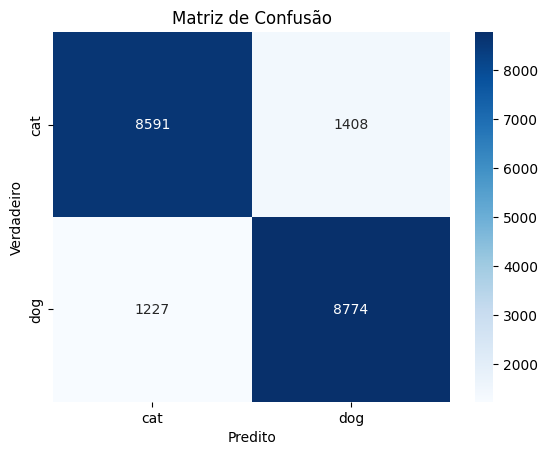

Resultados de Teste
Acurácia: 0.7646
F1 score: 0.7645926270570049


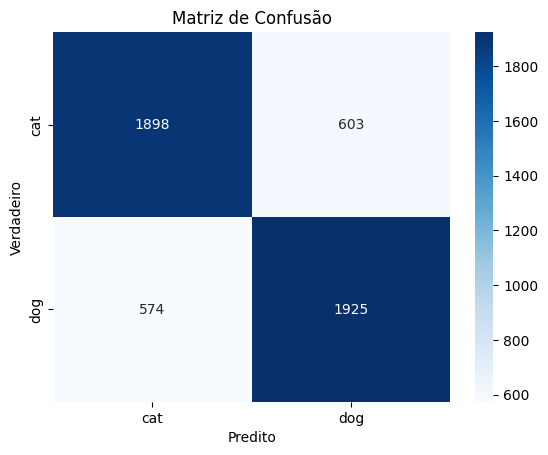

In [16]:
# Inferência e avaliação
def predict_and_evaluate_svm(model_svm, X_test_pca, y_test):

    # Inferência
    y_pred_svm = model_svm.predict(X_test_pca)

    # Métricas
    print('Acurácia:', accuracy_score(y_test, y_pred_svm))
    print('F1 score:', f1_score(y_test, y_pred_svm, average='weighted'))

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred_svm)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

print('Resultados de Treino')
predict_and_evaluate_svm(model_svm, X_train_pca, y_train)
print('Resultados de Teste')
predict_and_evaluate_svm(model_svm, X_test_pca, y_test)

In [17]:
y_pred_svm = model_svm.predict(X_test_pca)

In [18]:
import pandas as pd
results = pd.DataFrame()
results['id'] = list(range(1, y_pred_svm.shape[0] + 1))
results['label'] = y_pred_svm
results.head()

,id,label
0,1,cat
1,2,cat
2,3,dog
3,4,dog
4,5,cat


In [19]:
results.to_csv('results.csv', index=False)